<a href="https://colab.research.google.com/github/MileneCV/sales_predictions/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

name: Milene Carmes Vallejo

last updated: 12/26/2022

# Sales predictions 




## Project Description
We are going to use a dataset from https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/. It is a sales prediction for food sold in various stores. 

The goal of this project is to help the retailer better understand which products and what factors influence increasing sales.



## Data Dictionary

![sales_predictions](https://github.com/MileneCV/sales_predictions/blob/main/Picture1.png?raw=1)

## Import libraries



In [1]:
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
price_fmt = StrMethodFormatter("₹{x:,.0f}")
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
set_config(display='diagram')
import matplotlib.pyplot as plt
from matplotlib import legend
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor



## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/My Drive/sales_predictions.csv'
df_sales = pd.read_csv(filename)

df_sales.head()

Mounted at /content/drive


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Prepare/clean the data


### Display Rows and Column Count

In [3]:
df_sales.shape
print(f'There are {df_sales.shape[0]} rows, and {df_sales.shape[1]} columns.')
print(f'The rows represent {df_sales.shape[0]} observations, and the columns represent {df_sales.shape[1]-1} features and 1 target variable.')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


### Display Data Types

In [4]:
df_sales.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

### Display Column Names, Count of Non-Null Values, and Data Types

In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Duplicated Data

In [6]:
check_duplicate = df_sales.duplicated().sum()
if check_duplicate == 0:
  print('no duplicate were found to be dropped.')
else:
  print(f'(there are {check_duplicate} duplicates')


no duplicate were found to be dropped.


### Missing Values

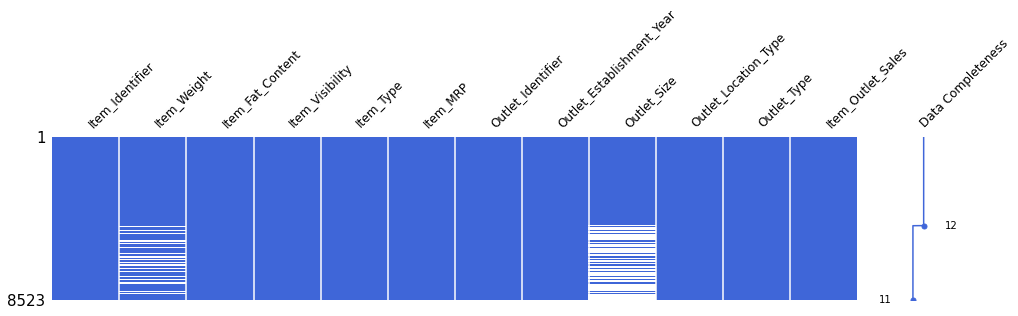

In [7]:
msno.matrix(df_sales, figsize=(16,3), labels=True, fontsize=12, sort="descending", color=	(.25,.4,.85));

In [8]:
df_sales.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Identifying % of missing data

In [9]:
df_sales.isna().sum()/len(df_sales)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

17% of item_weight column is missing but we can some of them with item_identifier : all identical 'Item_Identifier' should have the same 'Item_Weight'.

#### Item_Identifier column

In [10]:
# check 'Item_Identifier'
df_sales['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [11]:
# display nan in Item_weight column
nan_weight = df_sales[df_sales['Item_Weight'].isna()]
nan_weight


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [12]:
# create a new dataframe only with Item_Identifier and Item_Weight
df_ident_weight = df_sales[['Item_Identifier', 'Item_Weight']]
df_ident_weight

,Item_Identifier,Item_Weight
0,FDA15,9.300
1,DRC01,5.920
2,FDN15,17.500
3,FDX07,19.200
4,NCD19,8.930
...,...,...
8518,FDF22,6.865
8519,FDS36,8.380
8520,NCJ29,10.600
8521,FDN46,7.210


In [13]:
# drop nan from filter
df_ident_weight = df_ident_weight.dropna()
df_ident_weight 
# now we know all weight for each item_identifier 

,Item_Identifier,Item_Weight
0,FDA15,9.300
1,DRC01,5.920
2,FDN15,17.500
3,FDX07,19.200
4,NCD19,8.930
...,...,...
8518,FDF22,6.865
8519,FDS36,8.380
8520,NCJ29,10.600
8521,FDN46,7.210


In [14]:
# Lets merge df_ident_weight and df_sales
result = pd.merge(df_sales, df_ident_weight, on= 'Item_Identifier', how='inner')
result

,Item_Identifier,Item_Weight_x,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
1,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
2,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
3,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
4,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,NCW30,5.21,Low Fat,0.011008,Household,259.5962,OUT035,2004,Small,Tier 2,Supermarket Type1,2848.9582,5.21
41529,NCW05,20.25,Low Fat,0.148303,Health and Hygiene,108.3938,OUT049,1999,Medium,Tier 1,Supermarket Type1,2787.0388,20.25
41530,NCW05,20.25,Low Fat,0.148303,Health and Hygiene,108.3938,OUT049,1999,Medium,Tier 1,Supermarket Type1,2787.0388,20.25
41531,NCW05,20.25,Low Fat,0.148373,Health and Hygiene,108.8938,OUT045,2002,NaN,Tier 2,Supermarket Type1,3644.5892,20.25


In [15]:
# check missing values
result.isna().sum()

Item_Identifier                  0
Item_Weight_x                 6597
Item_Fat_Content                 0
Item_Visibility                  0
Item_Type                        0
Item_MRP                         0
Outlet_Identifier                0
Outlet_Establishment_Year        0
Outlet_Size                  12035
Outlet_Location_Type             0
Outlet_Type                      0
Item_Outlet_Sales                0
Item_Weight_y                    0
dtype: int64

In [16]:
# drop column Item_Weight_x with missing values and keep Item_Weight_y  
df_sales1 = result.drop(columns='Item_Weight_x')
df_sales1.isna().sum()

Item_Identifier                  0
Item_Fat_Content                 0
Item_Visibility                  0
Item_Type                        0
Item_MRP                         0
Outlet_Identifier                0
Outlet_Establishment_Year        0
Outlet_Size                  12035
Outlet_Location_Type             0
Outlet_Type                      0
Item_Outlet_Sales                0
Item_Weight_y                    0
dtype: int64

In [17]:
# set item_identifier as index
df_sales1.set_index('Item_Identifier')

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_y
Item_Identifier,,,,,,,,,,,
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
...,...,...,...,...,...,...,...,...,...,...,...
NCW30,Low Fat,0.011008,Household,259.5962,OUT035,2004,Small,Tier 2,Supermarket Type1,2848.9582,5.21
NCW05,Low Fat,0.148303,Health and Hygiene,108.3938,OUT049,1999,Medium,Tier 1,Supermarket Type1,2787.0388,20.25
NCW05,Low Fat,0.148303,Health and Hygiene,108.3938,OUT049,1999,Medium,Tier 1,Supermarket Type1,2787.0388,20.25


In [18]:
# drop duplicates
df_sales = df_sales1.drop_duplicates()
# check duplicates
df_sales.duplicated().sum()

0

In [19]:
df_sales.isna().sum()

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight_y                   0
dtype: int64

#### Outlet_Size column

In [20]:
# Let's try to find some clues  to fill missing values
df_sales.groupby(['Outlet_Type','Outlet_Location_Type'])['Outlet_Size'].unique()

Outlet_Type        Outlet_Location_Type
Grocery Store      Tier 1                          [Small]
                   Tier 3                            [nan]
Supermarket Type1  Tier 1                  [Medium, Small]
                   Tier 2                     [nan, Small]
                   Tier 3                           [High]
Supermarket Type2  Tier 3                         [Medium]
Supermarket Type3  Tier 3                         [Medium]
Name: Outlet_Size, dtype: object

There are missing values in Outlet_Location_Type tier 3 but we are unable to find some clues. Let's replace Nan with 'Unknown'.

In [21]:
df_sales['Outlet_Size'].fillna('Unknown',inplace=True)

In [22]:
# Confirm that there are no missing values after addressing them.
df_sales.isna().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Weight_y                0
dtype: int64

 7 - Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent).

### Find and fix any inconsistent categories of data

Check for common syntax errors, typos or inconsistencies in strings that need to be fixed.

In [23]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 41531
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Fat_Content           8519 non-null   object 
 2   Item_Visibility            8519 non-null   float64
 3   Item_Type                  8519 non-null   object 
 4   Item_MRP                   8519 non-null   float64
 5   Outlet_Identifier          8519 non-null   object 
 6   Outlet_Establishment_Year  8519 non-null   int64  
 7   Outlet_Size                8519 non-null   object 
 8   Outlet_Location_Type       8519 non-null   object 
 9   Outlet_Type                8519 non-null   object 
 10  Item_Outlet_Sales          8519 non-null   float64
 11  Item_Weight_y              8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


#### Object columns

In [1]:
# this code will fiter out the object type columns and creates a list of each of column names as an index
df_sales_types = df_sales.dtypes
str_cols = df_sales_types[df_sales_types=='object'].index
str_cols

NameError: name 'df_sales' is not defined

In [25]:
# This for loop prints out each column name and then lists each category
# in the column along with the counts of each category
for col in str_cols:
  print(f'- {col}:')
  print(df_sales[col].value_counts(dropna=False))
  print('\n')


- Item_Identifier:
FDG33    10
FDW13    10
FDV60     9
FDU12     9
FDX20     9
         ..
DRF48     1
FDY43     1
FDC23     1
FDO33     1
FDT35     1
Name: Item_Identifier, Length: 1555, dtype: int64


- Item_Fat_Content:
Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


- Item_Type:
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


- Outlet_Identifier:
OUT013    932
OUT027    932
OUT049    930
OUT035    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926


In [26]:
# something is wrong with "Item_fat_content"
# replace to be 2 type : Low Fat and Regular
# Define a dictionary with key/value pairs and use it to replace values
dict = {"low fat": 'Low Fat', "reg": 'Regular', "LF": 'Low Fat'}
df_sales.replace({'Item_Fat_Content': dict}, inplace = True)

In [27]:
# check 'Item_Fat_Content'
df_sales['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

#### Numeric columns

Obtain the summary statistics of each (min, max, mean).

In [28]:
df_sales.describe()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Weight_y
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,0.066112,141.010019,1997.837892,2181.188779,12.875420
std,0.051586,62.283594,8.369105,1706.511093,4.646098
min,0.000000,31.290000,1985.000000,33.290000,4.555000
25%,0.026983,93.844900,1987.000000,834.247400,8.785000
50%,0.053925,143.047000,1999.000000,1794.331000,12.650000
75%,0.094558,185.676600,2004.000000,3100.630600,16.850000
max,0.328391,266.888400,2009.000000,13086.964800,21.350000


No unusual statistics were noted.

## Exploratory Data Analysis

#### object columns

In [29]:
# select categorical columns
df_sales_types = df_sales.dtypes
str_cols = df_sales_types[df_sales_types=='object'].index
str_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [30]:
# Create a function to plot all string columns
def plot_bar_all_features(df1,x):
  fig, ax = plt.subplots(figsize=(8,5))
  counts_x = df1[x].value_counts()
  print(f'Value_counts {x}')
  print(counts_x)
  print('\n', '\n')
  counts_x.plot(kind='barh')
 
  ax.set_title(f'Frequencies of {x}', fontsize = 20, fontweight = 'bold');
  ax.set_ylabel(f'Categories for {x}', fontsize = 15, fontweight = 'bold')
  ax.set_xlabel('Counts', fontsize = 15, fontweight = 'bold')
 
 

Value_counts Item_Fat_Content
Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64

 



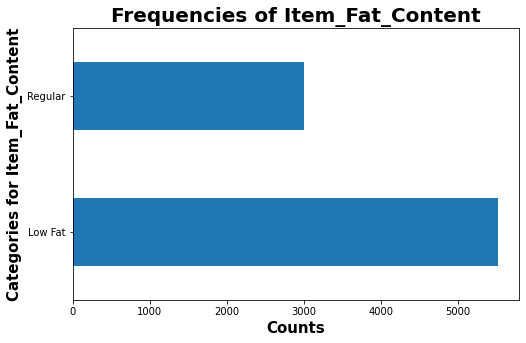

In [31]:
plot_bar_all_features(df_sales, 'Item_Fat_Content')

Value_counts Item_Type
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

 



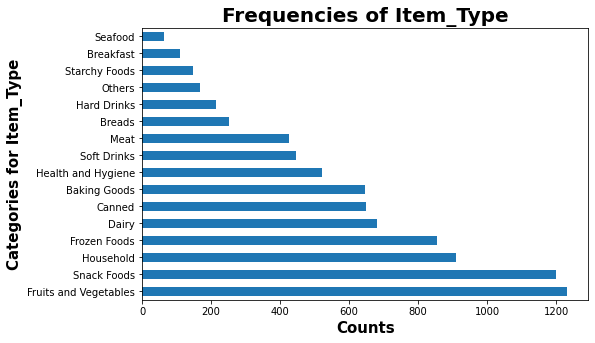

In [32]:
plot_bar_all_features(df_sales, 'Item_Type')

In this dataset there are more fruit/vegetables and snack foods(about 1200) and less sea food and breakfast (about 100).  

Value_counts Outlet_Establishment_Year
1985    1459
1987     932
1999     930
2004     930
1997     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

 



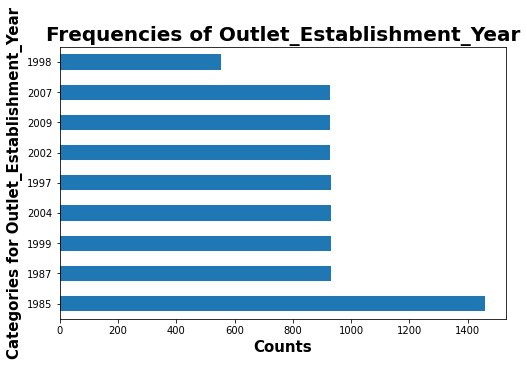

In [33]:
plot_bar_all_features(df_sales, 'Outlet_Establishment_Year')

Value_counts Outlet_Size
Medium     2790
Unknown    2410
Small      2387
High        932
Name: Outlet_Size, dtype: int64

 



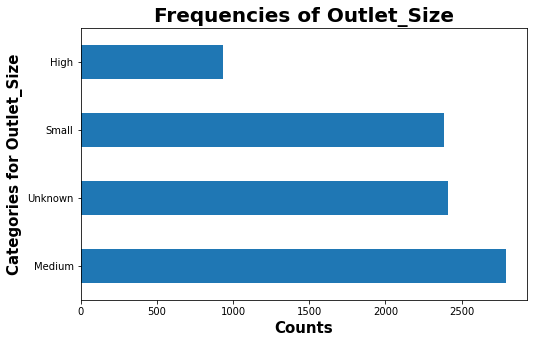

In [34]:
plot_bar_all_features(df_sales, 'Outlet_Size')

Value_counts Outlet_Location_Type
Tier 3    3347
Tier 2    2785
Tier 1    2387
Name: Outlet_Location_Type, dtype: int64

 



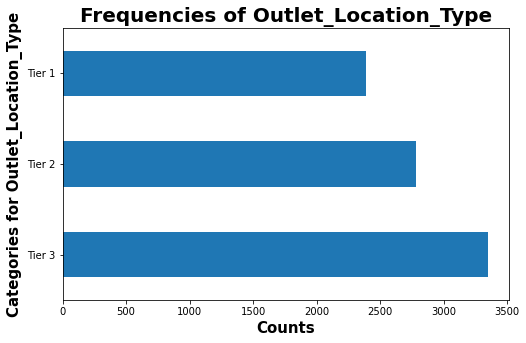

In [35]:
plot_bar_all_features(df_sales, 'Outlet_Location_Type')

Value_counts Outlet_Type
Supermarket Type1    5577
Grocery Store        1082
Supermarket Type3     932
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

 



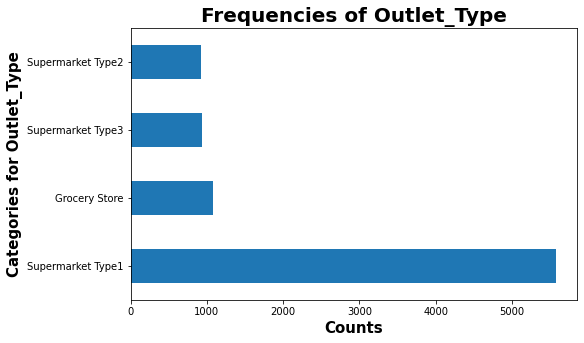

In [36]:
plot_bar_all_features(df_sales, 'Outlet_Type')

#### numeric columns

In [37]:
df_sales.describe()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Weight_y
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,0.066112,141.010019,1997.837892,2181.188779,12.875420
std,0.051586,62.283594,8.369105,1706.511093,4.646098
min,0.000000,31.290000,1985.000000,33.290000,4.555000
25%,0.026983,93.844900,1987.000000,834.247400,8.785000
50%,0.053925,143.047000,1999.000000,1794.331000,12.650000
75%,0.094558,185.676600,2004.000000,3100.630600,16.850000
max,0.328391,266.888400,2009.000000,13086.964800,21.350000


In [38]:
def plot_numeric(df,col):
  """EDA function to plot a histogram and boxplot for the selected column"""
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0], bins = 100)
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--', 
           label=f"Mean Value = ${mean_value:,.2f}",);
  axes[0].legend()

  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph 
  axes[0].set_title(f'Distribution of {col}', fontsize = 20, fontweight = 'bold')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()
     


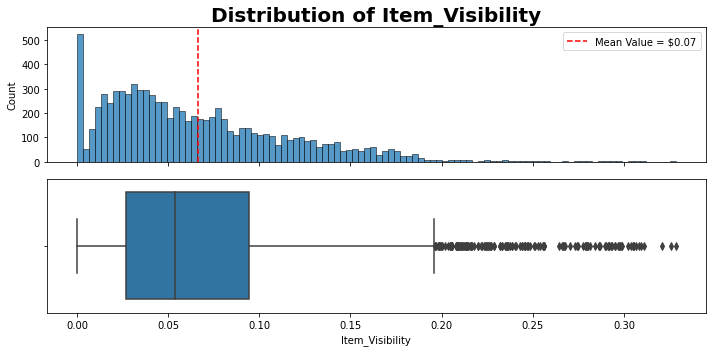

In [39]:
plot_numeric(df_sales,'Item_Visibility')

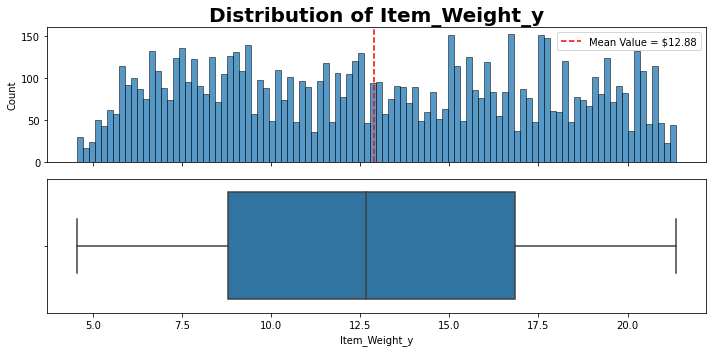

In [40]:
plot_numeric(df_sales,'Item_Weight_y')

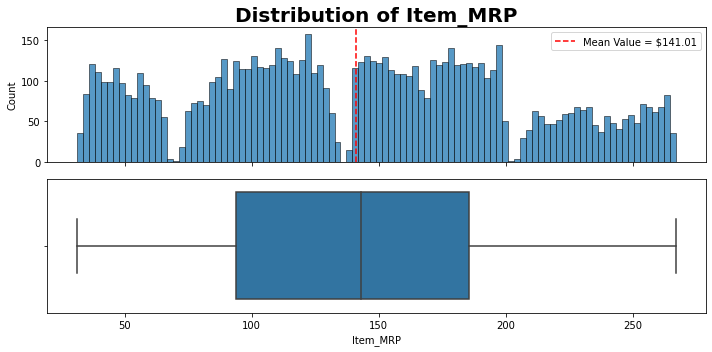

In [41]:
plot_numeric(df_sales,'Item_MRP')


Most of the products have a price between ₹30 and ₹190. The mean price is ₹141.01 and the maximun valor is about ₹260.  

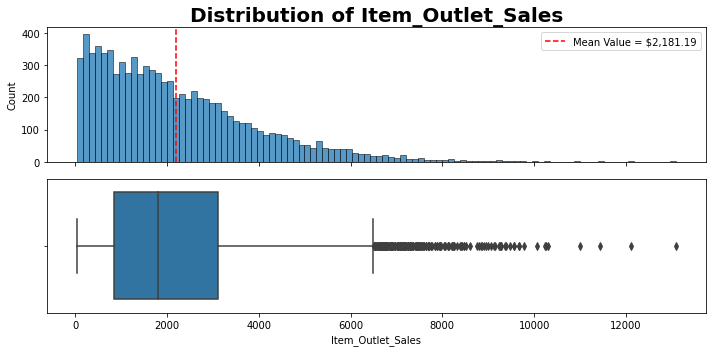

In [42]:
plot_numeric(df_sales,'Item_Outlet_Sales')

#### Correlation Heatmap

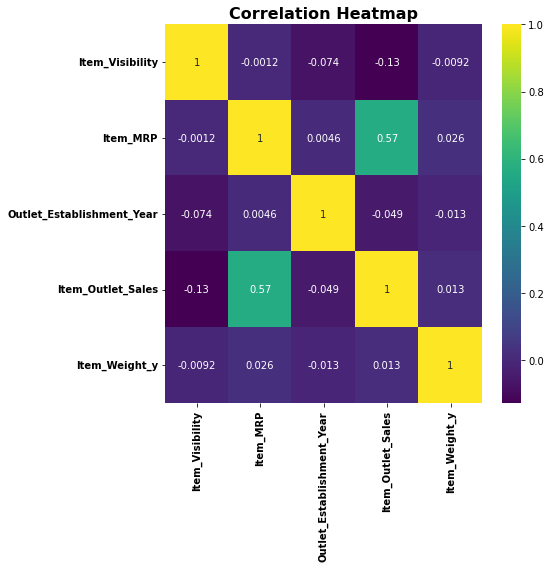

In [43]:
plt.figure(figsize = (8, 8))

corr = df_sales.corr()
sns.heatmap(corr, cmap='viridis', annot=True);

plt.title('Correlation Heatmap', fontsize = 16, weight='bold')
plt.xticks(fontsize = 10, weight='bold', rotation=90)
plt.yticks(fontsize = 10, weight='bold');

plt.tight_layout()
plt.show;

##### Observation:
Item MRP has the highest correlation to Item Outlet Sales.

## Explanatory Data Analysis

#### Correlation between price and sales

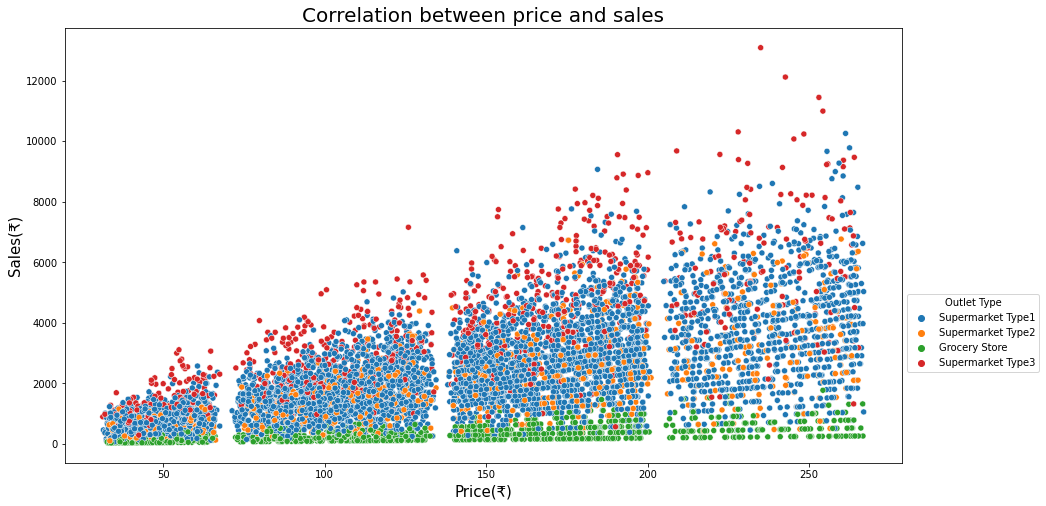

In [44]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_sales, x='Item_MRP', y='Item_Outlet_Sales', hue='Outlet_Type')
plt.title('Correlation between price and sales', fontsize=20)
plt.ylabel('Sales(₹)', fontsize=15)
plt.xlabel('Price(₹)', fontsize=15)

plt.legend(bbox_to_anchor=(1,0.4), title = 'Outlet Type')

plt.show()


In supermarket type 1, 2 and 3 there is a positive correlation between price and sales number. In grocery store is hard to see this correlation. 

#### Which Items generate the greatest amount of sales?

In [47]:
top_selling_item_types = df_sales.groupby('Item_Type')['Item_Outlet_Sales'].sum()
df_top = pd.DataFrame(top_selling_item_types).sort_values('Item_Outlet_Sales', ascending = False)
df_top

,Item_Outlet_Sales
Item_Type,
Fruits and Vegetables,2.820060e+06
Snack Foods,2.728352e+06
Household,2.055494e+06
Frozen Foods,1.824165e+06
Dairy,1.519141e+06
Canned,1.444151e+06
Baking Goods,1.265405e+06
Health and Hygiene,1.045200e+06
Meat,9.175656e+05


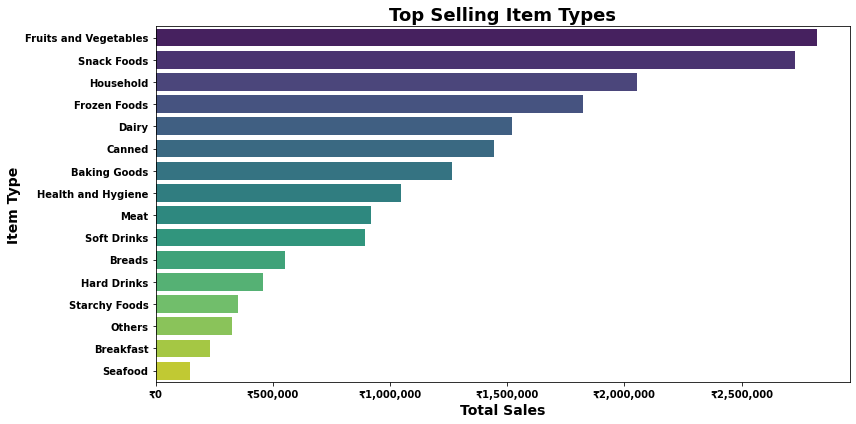

In [48]:

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=df_top, x='Item_Outlet_Sales', y=df_top.index, orient='h', palette='viridis'); 

plt.title('Top Selling Item Types', fontsize = 18, weight='bold')
plt.xlabel('Total Sales', fontsize = 14, weight='bold')
plt.ylabel('Item Type', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');
ax.xaxis.set_major_formatter(price_fmt)
plt.tight_layout()
plt.show;


Fruits and Vegetables and snack foods are the top selling item with more than ₹2,500,00 in sales.

#### Which outlet has better sales? 

In [49]:
# check outlet with better sales 
df_group_type_outlet = df_sales.groupby(['Outlet_Type', 'Outlet_Identifier'])['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales')
df_group_type_outlet

,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
1,Grocery Store,OUT019,1.795736e+05
0,Grocery Store,OUT010,1.883402e+05
8,Supermarket Type2,OUT018,1.851823e+06
5,Supermarket Type1,OUT045,2.036725e+06
6,Supermarket Type1,OUT046,2.118395e+06
2,Supermarket Type1,OUT013,2.142664e+06
3,Supermarket Type1,OUT017,2.167465e+06
7,Supermarket Type1,OUT049,2.183970e+06
4,Supermarket Type1,OUT035,2.268123e+06
9,Supermarket Type3,OUT027,3.444468e+06


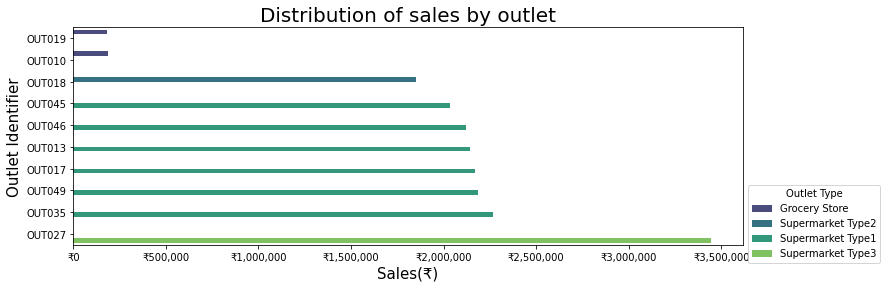

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=df_group_type_outlet, x='Item_Outlet_Sales', y='Outlet_Identifier', hue='Outlet_Type', palette='viridis', order=df_group_type_outlet['Outlet_Identifier'])
plt.legend(bbox_to_anchor=(1,0.3), title= 'Outlet Type' )
plt.title('Distribution of sales by outlet', fontsize=20)
plt.xlabel('Sales(₹)', fontsize=15)
plt.ylabel('Outlet Identifier', fontsize=15)
ax.xaxis.set_major_formatter(price_fmt)
plt.show()

The outlet OUT027, wich is a supermarket type 3, has better sales than other outlets. Grocery stores OUT010, OUT019 have lower sales. Supermarket Type1 contributed significantly of total sales

#### Which outlet type has better sales? 

In [51]:
# check outlet type with better sales 
df_group_type = df_sales.groupby(['Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales')
df_group_type

,Outlet_Type,Item_Outlet_Sales
0,Grocery Store,3.679138e+05
2,Supermarket Type2,1.851823e+06
3,Supermarket Type3,3.444468e+06
1,Supermarket Type1,1.291734e+07


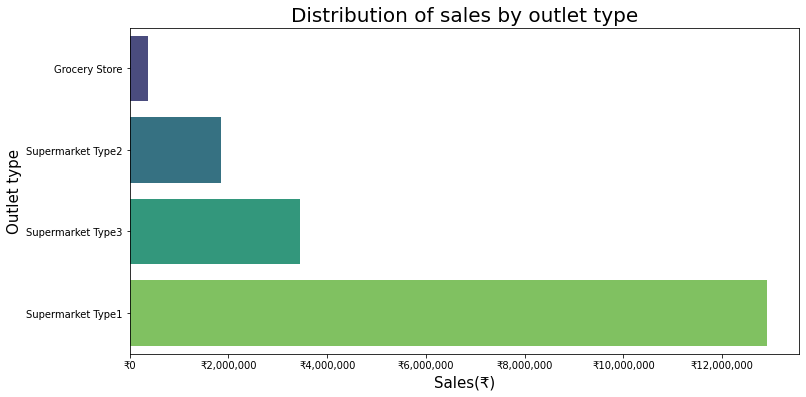

In [52]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_group_type, x='Item_Outlet_Sales', y='Outlet_Type', palette='viridis')

plt.title('Distribution of sales by outlet type', fontsize=20)
plt.xlabel('Sales(₹)', fontsize=15)
plt.ylabel('Outlet type', fontsize=15)
ax.xaxis.set_major_formatter(price_fmt)

Supermarket Type1 has higher total sales.

#### Does Location affect Sales?

In [53]:
location_sales_sorted = df_sales.groupby(['Outlet_Location_Type'])['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales')
location_sales_sorted

,Outlet_Location_Type,Item_Outlet_Sales
0,Tier 1,4.481939e+06
1,Tier 2,6.472314e+06
2,Tier 3,7.627295e+06


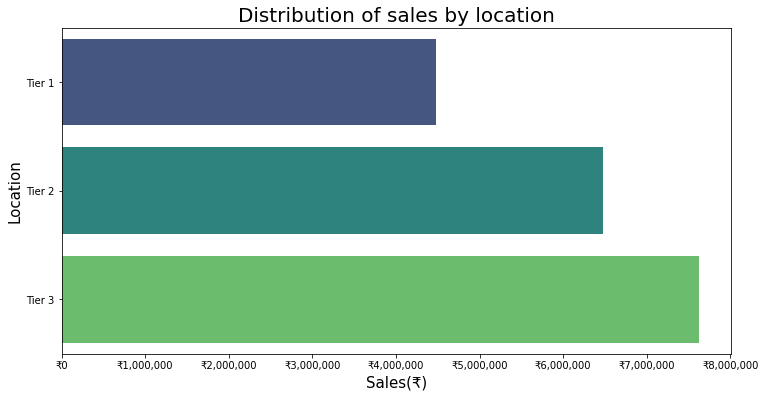

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=location_sales_sorted, x='Item_Outlet_Sales', y='Outlet_Location_Type', palette='viridis')
plt.title('Distribution of sales by location', fontsize=20)
plt.xlabel('Sales(₹)', fontsize=15)
plt.ylabel('Location', fontsize=15)
ax.xaxis.set_major_formatter(price_fmt)

Tier 3 Outlet Location has higher sales.

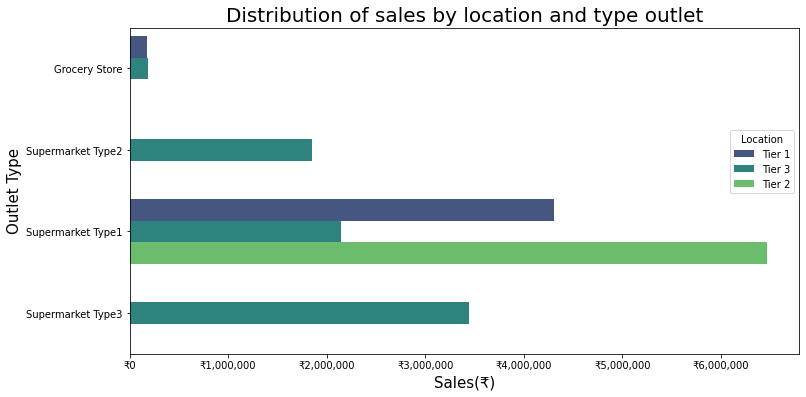

In [55]:
# check what type of outlet are in tier 3 
location_sales_sorted = df_sales.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales')
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=location_sales_sorted, x='Item_Outlet_Sales', y='Outlet_Type', hue= 'Outlet_Location_Type', palette='viridis')
plt.title('Distribution of sales by location and type outlet', fontsize=20)
plt.xlabel('Sales(₹)', fontsize=15)
plt.ylabel('Outlet Type', fontsize=15)
plt.legend(bbox_to_anchor=(1,0.7), title= 'Location')
ax.xaxis.set_major_formatter(price_fmt)

plt.show()



The type of the area in which the store is located is not related to better sales. Because at Tier 3 are located Supermarket type 3 with better sales and grocery store with lower sales. Supermarket type 1 are located in all tier and there is no sales difference.

### Does the year in which store was established is related with better sales? 

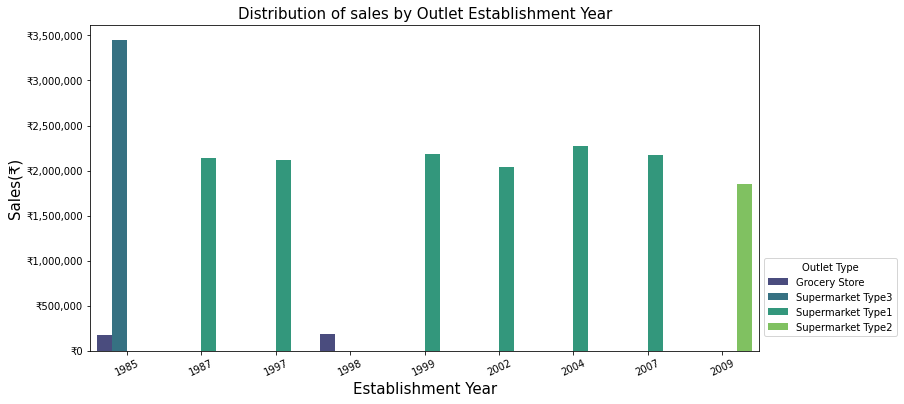

In [56]:
# check if The year in which store was established is related with better sales. 
year_sales = df_sales.groupby(['Outlet_Establishment_Year', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index().sort_values('Outlet_Establishment_Year')
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=year_sales, y='Item_Outlet_Sales', hue= 'Outlet_Type',  x = 'Outlet_Establishment_Year', palette='viridis')
plt.title('Distribution of sales by Outlet Establishment Year', fontsize=15)
plt.ylabel('Sales(₹)', fontsize=15)
plt.xlabel('Establishment Year', fontsize=15)
plt.legend(bbox_to_anchor=(1,0.3), title= 'Outlet Type')
plt.xticks(rotation = 90)
plt.xticks(rotation = 25)
ax.yaxis.set_major_formatter(price_fmt)
plt.show()


The year in which stores were established is not related to better sales. In 1985 were established Grocery Store with lower sales and Supermarket Type 3 with higher sales numbers.

# Preprocessing for Machine Learning 

In [57]:
# load df again for machine learning 
df_ml = pd.read_csv(filename)
df_ml


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [58]:
# fix inconsistencies in 'Item_Fat_Content' column
dict_names = {'LF':'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'}
df_ml['Item_Fat_Content']. replace(dict_names, inplace = True)
df_ml['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [59]:
# 'Outlet_Establishment_Year' is a date/time and will be included with categorical features
df_ml['Outlet_Establishment_Year'] = df_ml['Outlet_Establishment_Year'].astype("object")

## Train/Test split
"Item_Outlet_Sales" column as target

In [60]:
# matrix  - drop columns Outlet_Identifier, Outlet_Establishment_Year (these features will not make any contribution in model building)
X = df_ml.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])

# target
y = df_ml['Item_Outlet_Sales']

# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('size of X_train(75% of df_sales)')
print(len(X_train))



size of X_train(75% of df_sales)
6392


## Selector columns

In [61]:
# make selector columns:
# numerical columns
num_selector = make_column_selector(dtype_include = 'number')

# categorical columns
cat_selector = make_column_selector(dtype_include = 'object')

In [62]:
cat_selector(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [63]:
num_selector(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP']

## Impute any missing values.

In [64]:
# check missing values 
df_ml.isna().sum() 

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are missing values in numeric column Item_Weight that is float and categorical column Outlet_Size

Use the ‘mean’ strategy for numeric columns (that is a float number) and the ‘most_frequent’ strategy for categorical columns.



In [65]:
# categorical columns
freq_imputer = SimpleImputer(strategy='most_frequent')
# numeric columns
mean_imputer = SimpleImputer(strategy = 'mean')

## Instantiate Transformers : One HotEncoder and Scaler

In [66]:
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
scaler = StandardScaler()

## Instantiate Pipelines

In [67]:
# numeric pipeline 
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [68]:
# categorical pipeline 
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

## Instantiate ColumnTransformer

In [69]:
# tuples - first element is the transformer and second element is a ColumnSelector oject
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [70]:
# ColumTransformer, put all together: numerical and categorical columns 
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa1c112b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa21945e0>)])

## Fit and Transform Data

In [71]:
# Fit on Train
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa1c112b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa21945e0>)])

In [72]:
# Transform Train and Test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Inspect the Result

In [73]:

# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed
     

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 50)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

# Processing

#### Regression Metric Function

In [74]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

## Linear regression model

In [75]:
# instantiate a linear regression model
reg = LinearRegression()
# put preprocessor and linear regression model into a pipeline
reg_pipe = make_pipeline(preprocessor, reg)
# fit the pipe in the training data
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa1c112b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa21945e0>)])),
                ('linearregression', LinearRegression())])

###  Find predict values

In [76]:
train_pred_linear = reg_pipe.predict(X_train)
test_pred_linear = reg_pipe.predict(X_test) # these are predict values

### Evaluate the performance of your model based on r^2.

In [77]:
train_r2 = r2_score(y_train, train_pred_linear)
test_r2 = r2_score(y_test, test_pred_linear)

print(f'Model Training R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Training R2: 0.5615543076670946
Model Testing R2: 0.5671070270551657


This score can be interpreted as saying that linear regression model can account for about 56% of the variation in y_test using the features in X_test. This model is underfit.

### Evaluate the Model Using Regression Metrics

In [78]:
print('Testing')
# call the function
evaluate_regression(y_test, test_pred_linear)

Testing
scores: 
MAE: 804.12 
MSE: 1,194,341.88 
RMSE: 1,092.86 
R2: 0.57


In [79]:
print('Training')
evaluate_regression(y_train, train_pred_linear)

Training
scores: 
MAE: 847.14 
MSE: 1,297,560.61 
RMSE: 1,139.11 
R2: 0.56


## Randon Forest

In [92]:
rf = RandomForestRegressor(random_state = 42)

tree_reg_pipe_rf = make_pipeline(preprocessor, rf)
tree_reg_pipe_rf.fit(X_train, y_train)
train_pred_tree_rf = tree_reg_pipe_rf.predict(X_train)
test_pred_tree_rf = tree_reg_pipe_rf.predict(X_test)

print('Testing')
evaluate_regression(y_test, test_pred_tree_rf)

Testing
scores: 
MAE: 764.93 
MSE: 1,212,648.31 
RMSE: 1,101.20 
R2: 0.56


In [93]:
print('Training')
evaluate_regression(y_train, train_pred_tree_rf)

Training
scores: 
MAE: 296.43 
MSE: 182,357.11 
RMSE: 427.03 
R2: 0.94


It is overfitting, we can try to tunne it. 

### Tune RandomForest

In [94]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [95]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

42

In [96]:
n_ests = list(range(2,43)) 
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
  rf_9_tunned = RandomForestRegressor(max_depth=n, random_state=42)
  tree_reg_pipe_rf = make_pipeline(preprocessor, rf_9_tunned)
  tree_reg_pipe_rf.fit(X_train, y_train)
  train_pred_tree_rf = tree_reg_pipe_rf.predict(X_train)
  test_pred_tree_rf = tree_reg_pipe_rf.predict(X_test)
  scores2.loc[n, 'Train Score'] = r2_score(y_train, train_pred_tree_rf)
  scores2.loc[n, 'Test Score'] = r2_score(y_test, test_pred_tree_rf)

In [97]:
scores2.sort_values(by='Test Score', ascending=False)

,Test Score,Train Score
5,0.602702,0.61054
6,0.601242,0.624584
7,0.598598,0.6431
8,0.597013,0.666191
4,0.596632,0.595925
9,0.594551,0.692697
10,0.591419,0.721236
11,0.586892,0.751184
12,0.583715,0.780512
13,0.581509,0.807948


In [103]:
# The 'max_depth' with better Testing score was 5 
rf_5 = RandomForestRegressor(max_depth = 5, random_state = 42)

tree_reg_pipe_rf = make_pipeline(preprocessor, rf_5)
tree_reg_pipe_rf.fit(X_train, y_train)
train_pred_tree_rf = tree_reg_pipe_rf.predict(X_train)
test_pred_tree_rf = tree_reg_pipe_rf.predict(X_test)


### Evaluate the Model Using Regression Metrics

In [104]:
print('Testing')
evaluate_regression(y_test, test_pred_tree_rf)

Testing
scores: 
MAE: 728.32 
MSE: 1,096,135.55 
RMSE: 1,046.96 
R2: 0.60


In [99]:
print('Training')
evaluate_regression(y_train, train_pred_tree_rf)

Training
scores: 
MAE: 755.36 
MSE: 1,152,589.17 
RMSE: 1,073.59 
R2: 0.61


With max_depth= 5 we can see that in training datase R2 score is 60% that is better than default value 55%. But the score is not good, let's try tune the n_estimators.

In [100]:
# by default n_estimators': 100
# let's try another values:
n_ests = [250, 300, 350, 450]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
  rf_5_tunned = RandomForestRegressor(max_depth=5, n_estimators=n)
  tree_reg_pipe_rf = make_pipeline(preprocessor, rf_5_tunned)
  tree_reg_pipe_rf.fit(X_train, y_train)
  train_pred_tree_rf = tree_reg_pipe_rf.predict(X_train)
  test_pred_tree_rf = tree_reg_pipe_rf.predict(X_test)
  scores2.loc[n, 'Train Score'] = r2_score(y_train, train_pred_tree_rf)
  scores2.loc[n, 'Test Score'] = r2_score(y_test, test_pred_tree_rf)

In [101]:
scores2.head()

,Test Score,Train Score
250,0.603026,0.610739
300,0.602672,0.610432
350,0.603391,0.610446
450,0.603032,0.610543


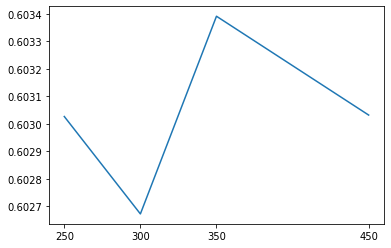

In [102]:
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);

We can see that we didn't improve the score of test dataset with tuning the n_estimators. It is 60%

## Decision Tree Regressor

In [80]:
# instantiate a model
dec_tree = DecisionTreeRegressor(random_state = 42)

# put the model in pipeline
# tree-based models do not required scaled data, but I will use the same preprocessor for all model 
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

# fit the model on the training data
dec_tree_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa1c112b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa21945e0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

### Find predict values

In [81]:
train_pred_dec_tree = dec_tree_pipe.predict(X_train)
test_pred_dec_tree = dec_tree_pipe.predict(X_test) # these are predict values 
# check predict Item_Outlet_Sales
test_pred_dec_tree

array([ 778.986 , 1249.0408, 1198.44  , ..., 1035.319 , 2780.3808,
       1330.2684])

### Evaluate the Model Using Regression Metrics

In [82]:
# Testing _score
print('Testing')
evaluate_regression(y_test, test_pred_dec_tree)

Testing
scores: 
MAE: 1,053.30 
MSE: 2,353,074.69 
RMSE: 1,533.97 
R2: 0.15


In [83]:
# training score
print('Training')
evaluate_regression(y_train, train_pred_dec_tree)

Training
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.00 
R2: 1.00


Decision Tree Model is overfit since the score of trainig is 100% and testing is only 11%. Let's try RandonForest Model

### Tune Decision tree model 

In [84]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

The default value for max_depth is None so the model we ran above was not limited. Before we start adjusting this parameter, lets check and see what the depth of our default tree was.

In [85]:
# check max_depth
dec_tree.get_depth()

44

In [86]:
# check how many leaf nodes
dec_tree.get_n_leaves()

6270

#### Finding the optimal max_depth (hyperparameter tuning)

In [87]:
# List of values to try for max_depth:
max_depth_range = list(range(2, 44)) # will try every value between 2 and 43
# List to store the score for each value of max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train_processed, y_train)
    score = dec_tree.score(X_test_processed, y_test)
    r2.append(score)

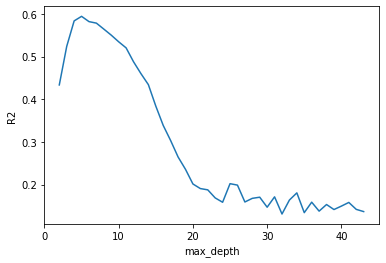

In [88]:
# Visualize which max_depth leads to the highest r2 score
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

It looks like the best score for the model is when the parameter max_depth is 5.

In [89]:
# Let's run the model with our optimized value for max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_processed, y_train)
train_5_score = dec_tree_5.score(X_train_processed, y_train)
test_5_score = dec_tree_5.score(X_test_processed, y_test)
print('Decision Tree with Tuned Parameters')
print(f'R2 Train Score: {train_5_score}')
print(f'R2 Test Score: {test_5_score}')

Decision Tree with Tuned Parameters
R2 Train Score: 0.6039397477322958
R2 Test Score: 0.5947099753159973


##### Evaluate the Model Using Regression Metrics

In [91]:
print('Training Scores for Decision Tree with Tuned Parameters')
evaluate_regression(y_train, dec_tree_5.predict(X_train_processed))
print('\n')
print('Testing Scores for Decision Tree with Tuned Parameters')
evaluate_regression(y_test, dec_tree_5.predict(X_test_processed))

Training Scores for Decision Tree with Tuned Parameters
scores: 
MAE: 762.61 
MSE: 1,172,122.77 
RMSE: 1,082.65 
R2: 0.60


Testing Scores for Decision Tree with Tuned Parameters
scores: 
MAE: 738.32 
MSE: 1,118,185.97 
RMSE: 1,057.44 
R2: 0.59


The r2 score is higher in Tune Decesion Tree model than Linear Regression model. 

##  Model Comparison

#### **Compare the performance of models based on R2.**

With the linear regression model, the R2 score in the training dataset was 56%, with the decision tree and random forest model after tenning were 60%.

These scores can be interpreted as saying that the linear regression model can account for about 56% of the variation in y_test using the features in X_test. The decision tree and random forest model can account for about 60% .

#### **Compare the performance of models based on MSE.**

A lower MSE is better as we want to reduce the size of errors, especially large errors!

The mean of the target is 2095.231046 and if we check MSE in all models were:

1 -linear regression was MSE: 1,198,492.82,

2 - decision tree regressor was 1,057.44

3 - random forest: 1,046.96

The MSE was lower with random forest regression but was too far from the mean target and any model had a score higher than 60%. We need to repeat this prediction with more features, the machine needs more data to learn and do a good prediction. Maybe we can improve the score with a more complex model.